In [1]:
import pandas as pd
import numpy as np
import os
import json
import pyodbc
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from etl.load_data import create_access_token

## Retrieve most recent data

In [2]:
def get_data(sql, config):
    conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + config['db_host'] +';DATABASE=' + config['db_name'] +';UID='+config['db_user'] +';PWD='+ config['db_password'] )
    cursor = conn.cursor()

    cursor.execute(sql)

    result = cursor.fetchall()

    headers = [column[0] for column in cursor.description]
    
    cursor.close()
    conn.close()
    
    return result, headers

In [3]:
with open('etl/config.json') as json_data:
    config = json.load(json_data)

with open("sql/get_data.sql", "r") as f:
    sql = f.read()

In [4]:
result, headers = get_data(sql, config)

In [5]:
with open('auction_data.csv', 'w', newline='') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(headers)
    for row in result:
        csv_out.writerow(row)

## Read data from CSV and data preparation

In [6]:
df = pd.read_csv('auction_data.csv')
df.head(10)

,Id,ItemId,BidGold,BidSilver,BuyoutGold,BuyoutSilver,Quantity,TimeLeft,Rand,Seed,...,RequiredLevel,ItemClass,ItemSubClass,PurchasePriceGold,PurchasePriceSilver,SellPriceGold,SellPriceSilver,MaxCount,IsEquippable,IsStackable
0,1420561355,3369,0,9,0,10,1,VERY_LONG,NaN,NaN,...,0,Trade Goods,Herb,0,1,0,0,0,False,True
1,1420708508,2632,0,99,1,49,1,VERY_LONG,1547.0,1.395594e+09,...,9,Weapon,Dagger,0,30,0,6,0,True,False
2,1420352186,2934,0,32,0,34,10,LONG,NaN,NaN,...,0,Trade Goods,Leather,0,0,0,0,0,False,True
3,1420555958,8150,0,26,0,28,1,VERY_LONG,NaN,NaN,...,0,Trade Goods,Leather,0,10,0,2,0,False,True
4,1419889906,5498,0,21,0,23,1,LONG,NaN,NaN,...,0,Gem,Simple,0,8,0,2,0,False,True
5,1420377502,3823,5,7,5,8,5,LONG,NaN,NaN,...,23,Consumable,Potion,0,4,0,1,0,False,True
6,1419746883,3818,0,7,0,7,1,LONG,NaN,NaN,...,0,Trade Goods,Herb,0,5,0,1,0,False,True
7,1420300160,5784,0,8,0,8,1,LONG,NaN,NaN,...,0,Trade Goods,Leather,0,3,0,0,0,False,True
8,1420350036,10998,1,12,1,16,1,LONG,NaN,NaN,...,0,Trade Goods,Enchanting,0,30,0,0,0,False,True
9,1420765058,7909,0,12,911,21,1,VERY_LONG,NaN,NaN,...,0,Gem,Simple,0,40,0,10,0,False,True


In [7]:
df.shape

(25126, 28)

In [8]:
df['TimeLeft'].value_counts()

VERY_LONG    13301
LONG          9925
SHORT         1183
MEDIUM         717
Name: TimeLeft, dtype: int64

### Since we can't know if an item was sold or just expired, we'll focus on VERY_LONG time left items (between 12 and 48 hours left)

In [9]:
df = df[df['TimeLeft'] == 'VERY_LONG']

In [10]:
df.loc[:,'Sold'] = df['TimesSeen'] <= 45

In [11]:
columns = ['Id', 'ItemName', 'Quantity', 'TimeLeft', 'ItemClass', 'TimesSeen', 'Sold']
df[columns].head(10)

,Id,ItemName,Quantity,TimeLeft,ItemClass,TimesSeen,Sold
0,1420561355,Grave Moss,1,VERY_LONG,Trade Goods,17,True
1,1420708508,Curved Dagger,1,VERY_LONG,Weapon,19,True
3,1420555958,Deeprock Salt,1,VERY_LONG,Trade Goods,17,True
9,1420765058,Aquamarine,1,VERY_LONG,Gem,17,True
11,1420555779,Silk Cloth,1,VERY_LONG,Trade Goods,11,True
14,1420562428,Grave Moss,1,VERY_LONG,Trade Goods,17,True
16,1420552958,Shadow Silk,1,VERY_LONG,Trade Goods,17,True
18,1420816319,Talon of Vultros,1,VERY_LONG,Weapon,20,True
19,1420902469,Bronze Tube,10,VERY_LONG,Trade Goods,21,True
20,1420917057,Peacebloom,20,VERY_LONG,Trade Goods,21,True


## Exploratory Data Analysis

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13301 entries, 0 to 25125
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   13301 non-null  int64  
 1   ItemId               13301 non-null  int64  
 2   BidGold              13301 non-null  int64  
 3   BidSilver            13301 non-null  int64  
 4   BuyoutGold           13301 non-null  int64  
 5   BuyoutSilver         13301 non-null  int64  
 6   Quantity             13301 non-null  int64  
 7   TimeLeft             13301 non-null  object 
 8   Rand                 625 non-null    float64
 9   Seed                 625 non-null    float64
 10  FirstTimeSeenYear    13301 non-null  int64  
 11  FirstTimeSeenMonth   13301 non-null  int64  
 12  FirstTimeSeenDay     13301 non-null  int64  
 13  FirstTimeSeenHour    13301 non-null  int64  
 14  TimesSeen            13301 non-null  int64  
 15  ItemName             13301 non-null 

In [13]:
columns = ['BidGold', 'BidSilver', 'BuyoutGold', 'BuyoutSilver', 'Quantity', 'TimesSeen', 'IsEquippable']
df[columns].describe()

,BidGold,BidSilver,BuyoutGold,BuyoutSilver,Quantity,TimesSeen
count,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000,13301.000000
mean,10.849184,38.155101,27.624164,44.196677,6.318247,21.983234
std,266.723136,32.966672,843.148621,35.654269,11.486140,14.844095
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,6.000000,0.000000,9.000000,1.000000,7.000000
50%,1.000000,34.000000,1.000000,41.000000,1.000000,22.000000
75%,5.000000,66.000000,6.000000,79.000000,10.000000,31.000000
max,16401.000000,99.000000,90000.000000,99.000000,200.000000,51.000000


## Percentage of items sold

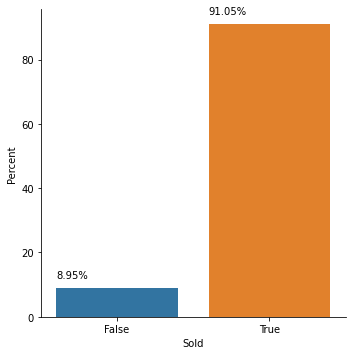

In [14]:
df_count = df['Sold'].value_counts(normalize=True)
df_count = df_count.mul(100)
df_count = df_count.rename('Percent').reset_index()
df_count['Sold'] = df_count['index'] 

g = sns.catplot(x='Sold', y='Percent', kind='bar', data=df_count)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height() + 3
    g.ax.text(txt_x,txt_y,txt)

## Most popular Item

                    ItemName  Counts
1418              Wool Cloth     513
702            Light Leather     352
738           Medium Leather     266
1176              Silk Cloth     210
718          Mageweave Cloth     200
1372             Vision Dust     178
1076  Savory Deviate Delight     150
1067          Rugged Leather     139
704              Linen Cloth     130
1061             Rough Stone     130


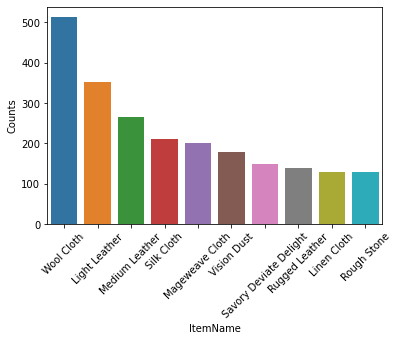

In [15]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemName']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='ItemName', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Most popular Item Class

        ItemClass  Counts
9     Trade Goods    7303
1      Consumable    1812
0           Armor    1179
3             Gem     457
8          Recipe     396
10         Weapon     382
6           Quest     375
4   Miscellaneous      90
2       Container      83
5      Projectile      27
7          Quiver       6


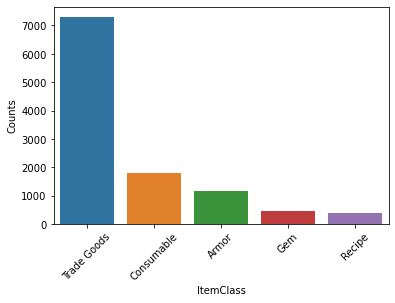

In [16]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemClass']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(100))

plot = sns.barplot(x='ItemClass', y='Counts', data=count_items[:5])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Most popular Item Subclass

     ItemSubClass  Counts
9           Cloth    1614
30  Metal & Stone    1601
25        Leather    1573
16     Enchanting    1050
22           Herb     741
15         Elixir     520
37         Potion     514
29           Meat     471
43         Simple     457
38          Quest     375


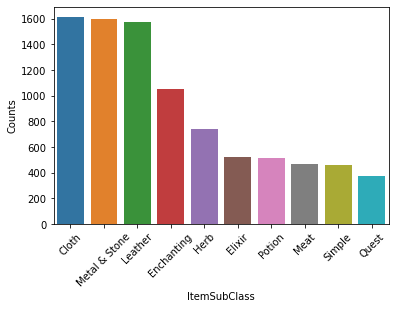

In [17]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['ItemSubClass']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='ItemSubClass', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Most sold quality tipe

    Quality  Counts
0    Common    8951
4  Uncommon    2650
3      Rare     425
1      Epic      43
2      Poor      41


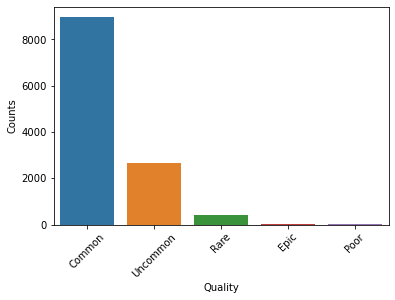

In [18]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['Quality']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)

print(count_items.head(10))

plot = sns.barplot(x='Quality', y='Counts', data=count_items[:10])
for item in plot.get_xticklabels():
    item.set_rotation(45)

## Are most sold items equippable?

   IsEquippable  Counts
0         False   10426
1          True    1684


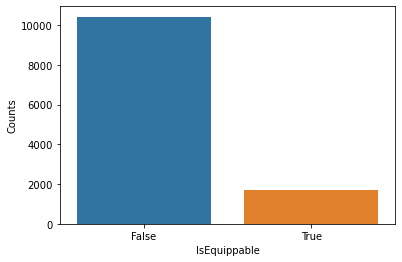

In [19]:
items_sold = df[df['Sold'] == 1]

count_items = items_sold.groupby(['IsEquippable']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)[:10]

print(count_items.head())

plot = sns.barplot(x='IsEquippable', y='Counts', data=count_items)

## Best week day to sell

   WeekDay  Counts
0        5   12271
1        6    1030


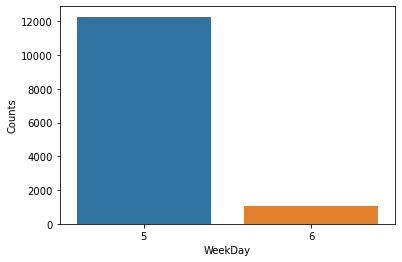

In [20]:
import datetime

df['WeekDay'] = df.apply(lambda row: datetime.datetime(row['FirstTimeSeenYear'], row['FirstTimeSeenMonth'], row['FirstTimeSeenDay']).weekday(), axis=1)

count_items = df.groupby(['WeekDay']).size().reset_index(name='Counts')
count_items = count_items.sort_values(by=['Counts'], ascending=False)[:10]

print(count_items.head(10))

plot = sns.barplot(x='WeekDay', y='Counts', data=count_items)